Code to analyze gas temperature in a 2k bottle

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary
import os

# https://refprop-docs.readthedocs.io/en/latest/DLL/high_level.html#f/_/REFPROPdll

In [17]:
def fluid_temp_from_P_D(fluid, p_pa, density):
    """
    Inputs:
        fluid: string of fluid to analyze 
        p_pa: pressure of the fluid, in Pascals
        density: density of the fluid, in kg/m^3
    
    Output: temperature of the gas
    """
    RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])
    RP.SETPATHdll(os.environ['RPPREFIX'])
    MOLAR_BASE_SI = RP.GETENUMdll(0,"MASS SI").iEnum
    r = RP.REFPROPdll(fluid,"PD","T",MOLAR_BASE_SI, 0,0,p_pa/1000000, density, [1.0])
    return r.Output[0]

def fluid_density_from_P_T(fluid, p_pa, temperature):
    """
    Inputs:
        fluid: string of fluid to analyze
        p_pa: pressure of the fluid, in Pascals
        temperature: temperature of the fluid, in Kelvin
    
    Output: density of the gas
    """
    RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])
    RP.SETPATHdll(os.environ['RPPREFIX'])
    MOLAR_BASE_SI = RP.GETENUMdll(0,"MASS SI").iEnum
    r = RP.REFPROPdll(fluid,"TP","D",MOLAR_BASE_SI, 0,0,temperature, p_pa/1000000, [1.0])
    return r.Output[0]

def fluid_pressure_from_T_D(fluid, temperature, density):
    """
    Inputs:
        fluid: string of fluid to analyze
        temperature: temperature of the fluid, in Kelvin
        density: density of the fluid kg/m^3
    
    Output: pressure of the gas
    """
    RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])
    RP.SETPATHdll(os.environ['RPPREFIX'])
    MOLAR_BASE_SI = RP.GETENUMdll(0,"MASS SI").iEnum
    r = RP.REFPROPdll(fluid,"TD","P",MOLAR_BASE_SI, 0,0,temperature, density, [1.0])
    return r.Output[0]

def fluid_gamma_from_P_T(fluid, p_pa, temperature):
    """
    Inputs:
        fluid: string of fluid to analyze
        p_pa: pressure of the fluid, in Pascals
        temperature: temperature of the fluid, in Kelvin
    
    Output: density of the gas
    """
    RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])
    RP.SETPATHdll(os.environ['RPPREFIX'])
    MOLAR_BASE_SI = RP.GETENUMdll(0,"MASS SI").iEnum
    r = RP.REFPROPdll(fluid,"TP","ISENK",MOLAR_BASE_SI, 0,0,temperature, p_pa/1000000, [1.0])
    return r.Output[0]

def convert_psi_to_pa(p_in_psi):
    # source: google
    return p_in_psi*6894.76

# If the RPPREFIX environment variable is not already set by your installer (e.g., on windows), 
# then uncomment this line and set the absolute path to the location of your install of 
# REFPROP
os.environ['RPPREFIX'] = r'C:\Program Files (x86)\REFPROP'

# Print the version of REFPROP in use and the NBP
out = fluid_temp_from_P_D("NITROGEN", 101325, 1.183160685)
out2 = fluid_gamma_from_P_T("NITROGEN", 101325, 288)
print(out2)

1.4011083176566845


In [18]:
volume = 0.040				# cubic meters
p_init = 2000				# psi
t_init = 280				# Kelvin
mdot_out = 0.105 		# kg/s
dt = 0.1					# seconds
fluid_to_use = "NITROGEN"	# name of fluid to use for simulation
p_init_pa = convert_psi_to_pa(p_init)

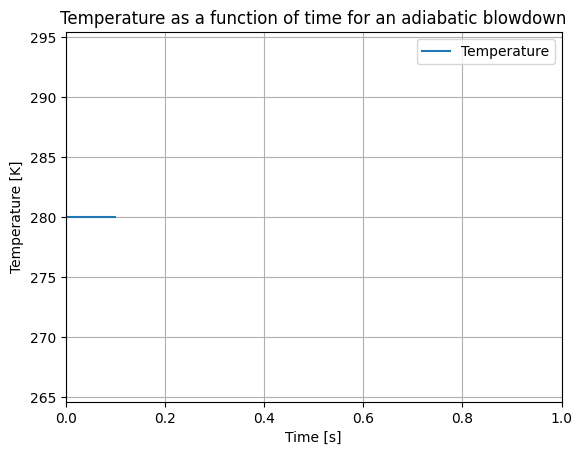

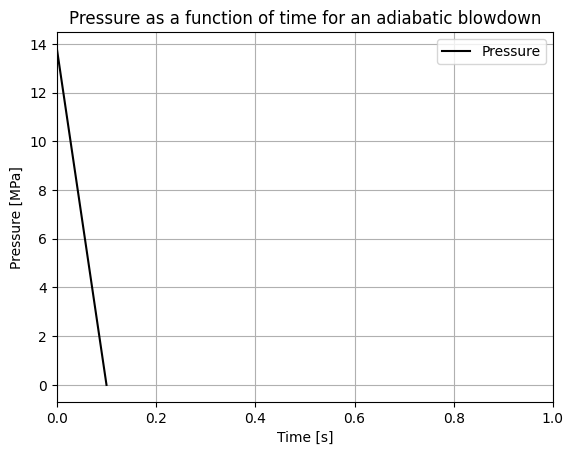

In [23]:
# isothermal
density = [fluid_density_from_P_T(fluid_to_use, p_init_pa, t_init)]
mass = [density[0]*volume]
gas_temp = [t_init]
gas_pressure = [p_init_pa]
time_vec = [0]
i = 0
while gas_pressure[i] > 9000000:
	time_vec += [time_vec[i]+dt]
	# use gamma from previous timestep
	gamma = fluid_gamma_from_P_T(fluid_to_use, gas_pressure[i], gas_temp[i])
	mass += [mass[i] - (mdot_out*dt)]
	density += [mass[i+1]/volume]
	gas_temp += [gas_temp[i]]
	gas_pressure += [fluid_pressure_from_T_D(fluid_to_use, gas_temp[i+1], density[i+1])]
	i += 1


plt.figure()
plt.plot(time_vec, gas_temp)
plt.ylabel("Temperature [K]")
plt.title("Temperature as a function of time for an adiabatic blowdown")
plt.xlabel("Time [s]")
plt.xlim([0,int(np.max(time_vec)+1)])
plt.grid()
plt.legend(["Temperature"])


plt.figure()
plt.plot(time_vec, np.divide(gas_pressure, 1000000), 'k')
plt.ylabel("Pressure [MPa]")
plt.title("Pressure as a function of time for an adiabatic blowdown")
plt.xlabel("Time [s]")
plt.xlim([0,int(np.max(time_vec)+1)])
plt.grid()
plt.legend(["Pressure"])


In [20]:
# adiabatic expansion
# find initial density to find mass of gas in bottle

density = [fluid_density_from_P_T(fluid_to_use, p_init_pa, t_init)]
mass = [density[0]*volume]
gas_temp = [t_init]
gas_pressure = [p_init_pa]
time_vec = [0]
i = 0
while gas_temp[i] > 233.15:
	time_vec += [time_vec[i]+dt]
	# use gamma from previous timestep
	gamma = fluid_gamma_from_P_T(fluid_to_use, gas_pressure[i], gas_temp[i])
	mass += [mass[i] - (mdot_out*dt)]
	density += [mass[i+1]/volume]
	ratio = (density[i+1]/density[i])**gamma
	gas_pressure += [gas_pressure[i]*ratio]
	gas_temp += [gas_temp[i]*(ratio**((gamma-1)/gamma))]
	#print(gas_temp[i])
	i+=1

#print(mass)


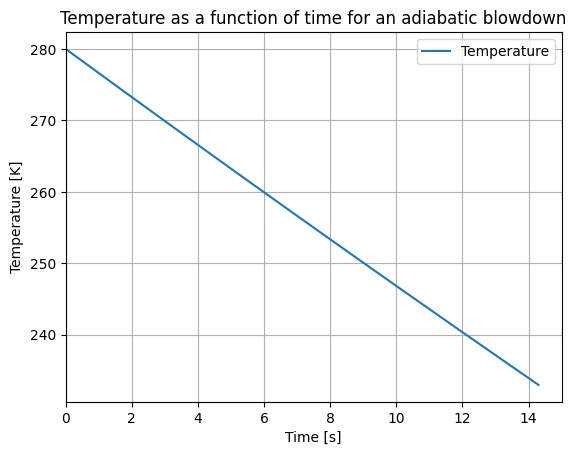

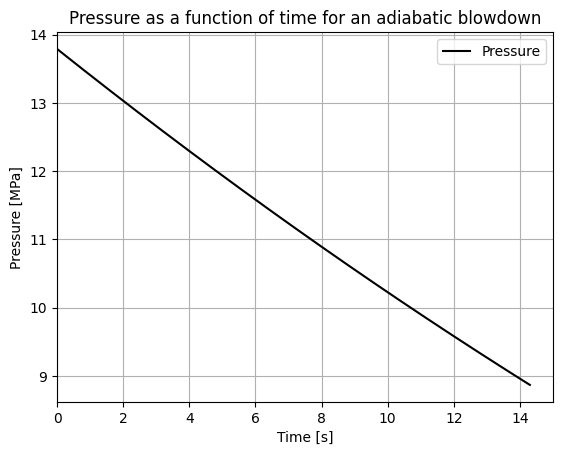

In [21]:
plt.figure()
plt.plot(time_vec, gas_temp)
plt.ylabel("Temperature [K]")
plt.title("Temperature as a function of time for an adiabatic blowdown")
plt.xlabel("Time [s]")
plt.xlim([0,int(np.max(time_vec)+1)])
plt.grid()
plt.legend(["Temperature"])


plt.figure()
plt.plot(time_vec, np.divide(gas_pressure, 1000000), 'k')
plt.ylabel("Pressure [MPa]")
plt.title("Pressure as a function of time for an adiabatic blowdown")
plt.xlabel("Time [s]")
plt.xlim([0,int(np.max(time_vec)+1)])
plt.grid()
plt.legend(["Pressure"])
